In [58]:
import os
import sys

sys.path.append(os.getcwd() + '/')

In [59]:
from experiments import setup_experiments

exps = setup_experiments("far_bias")

In [60]:
exps.path

'/data/Data/SimBA-MACAW/far_bias'

In [61]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

no_bias_dir = Path('/data/Data/SimBA-MACAW/no_bias/data/images/test')
far_bias_dir = Path(exps.path) / 'data' / 'images' / 'test'
far_bias_csv = Path(exps.path) / 'data' / 'csv' / 'test.csv'

macaw_cf_dir = Path(exps.path) / 'macaw_cfs' / 'no_bias'
hvae_cf_dir = Path(exps.path) / 'hvae_cfs' / 'no_bias'

macaw_pred_csv = Path(exps.path) / 'macaw_cfs' / 'no_bias' / 'predictions.csv'
hvae_pred_csv = Path(exps.path) / 'hvae_cfs' / 'no_bias' / 'predictions.csv'

df = pd.read_csv(far_bias_csv, low_memory=True)

macaw_pred_df = pd.read_csv(macaw_pred_csv, low_memory=True)
macaw_pred_dict = dict(zip(macaw_pred_df['filename'], macaw_pred_df['predictions']))
df['MACAW_sfcn_pred'] = df['filename'].map(macaw_pred_dict)

hvae_pred_df = pd.read_csv(hvae_pred_csv, low_memory=True)
hvae_pred_dict = dict(zip(hvae_pred_df['filename'], hvae_pred_df['predictions']))
df['HVAE_sfcn_pred'] = df['filename'].map(hvae_pred_dict)

df = df[df['bias_label'] == 1]
df['filename'] = [f.replace('nii.gz', 'tiff') for f in df['filename']]

In [62]:
df

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filepath,filename,MACAW_sfcn_pred,HVAE_sfcn_pred
0,309,0.570336,-0.109053,5,3,5_3,1,1,1_1_3_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00000_0.57_S_-0.109_D_0.567_B.tiff,0,0
1,645,-0.997365,-1.155688,3,5,3_5,1,0,0_1_5_3,/home/emma/Documents/SBB/datasets/exp140/test/...,00001_-0.997_S_-1.156_D_2.455_B.tiff,0,0
2,480,0.374307,-3.174221,5,1,5_1,1,0,0_1_1_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00002_0.374_S_-3.174_D_2.504_B.tiff,0,0
3,527,0.050704,-1.531272,4,4,4_4,1,0,0_1_4_4,/home/emma/Documents/SBB/datasets/exp140/test/...,00003_0.051_S_-1.531_D_-0.152_B.tiff,0,0
4,895,0.463769,0.758908,5,5,5_5,1,1,1_1_5_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00004_0.464_S_0.759_D_3.099_B.tiff,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1001,-0.925206,1.391593,3,6,3_6,1,1,1_1_6_3,/home/emma/Documents/SBB/datasets/exp140/test/...,00243_-0.925_S_1.392_D_3.152_B.tiff,0,0
244,360,-0.470277,-1.305675,3,4,3_4,1,0,0_1_4_3,/home/emma/Documents/SBB/datasets/exp140/test/...,00244_-0.47_S_-1.306_D_2.336_B.tiff,0,0
245,231,0.451993,0.217025,5,4,5_4,1,1,1_1_4_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00245_0.452_S_0.217_D_2.801_B.tiff,0,0
246,102,0.563755,0.076722,5,7,5_7,1,0,0_1_7_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00246_0.564_S_0.077_D_5.111_B.tiff,0,0


In [64]:
import numpy as np
from tifffile import tifffile as tiff




def four_images(idx):
    no_bias_img = tiff.imread(os.path.join(no_bias_dir, df.iloc[idx]['filename'])).squeeze()
    far_bias_img = tiff.imread(os.path.join(far_bias_dir, df.iloc[idx]['filename'])).squeeze()
    macaw_cf_img = tiff.imread(os.path.join(macaw_cf_dir, df.iloc[idx]['filename'])).squeeze()
    hvae_cf_img = tiff.imread(os.path.join(hvae_cf_dir, df.iloc[idx]['filename'])).squeeze()
   
    return no_bias_img, far_bias_img, macaw_cf_img, hvae_cf_img

In [65]:
# no_bias_img, far_bias_img, macaw_cf_img = three_images(np.random.randint(0,n,1).squeeze())

def view_images(idx):
    no_bias_img, far_bias_img, macaw_cf_img, hvae_cf_img = four_images(idx)
    
    print(np.max(no_bias_img), np.min(no_bias_img))
    print(np.max(macaw_cf_img), np.min(macaw_cf_img))
    print(np.max(hvae_cf_img), np.min(hvae_cf_img))
    

    fig, axs = plt.subplots(2, 4, figsize=(10, 4))
    [a.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) for ax in axs for a in ax]

    axs[0, 0].imshow(no_bias_img)
    axs[0, 0].set_title("No Bias")

    axs[0, 1].imshow(far_bias_img)
    axs[0, 1].set_title("Far Bias")

    axs[0, 2].imshow(macaw_cf_img)
    axs[0, 2].set_title("MACAW CF")

    axs[0, 3].imshow(hvae_cf_img)
    axs[0, 3].set_title("HVAE CF")

    axs[1, 0].imshow(far_bias_img - no_bias_img, cmap='seismic', clim=(-1, 1))
    axs[1, 0].set_title("Far - No")

    axs[1, 1].imshow(macaw_cf_img - no_bias_img, cmap='seismic', clim=(-1, 1))
    axs[1, 1].set_title("MACAW CF - No")

    axs[1, 2].imshow(hvae_cf_img - no_bias_img, cmap='seismic', clim=(-1, 1))
    axs[1, 2].set_title("HVAE CF - No")
    
    fig.savefig('diff.png')

In [66]:
def TEA(no_bias_img, far_bias_img, cf_img):
    no_far = (no_bias_img - far_bias_img).flatten()
    cf_far = (cf_img - far_bias_img).flatten()

    no_far_mag = np.linalg.norm(no_far)
    cf_far_mag = np.linalg.norm(cf_far)
    projection = no_far.dot(cf_far) / no_far_mag

    bias_removal = projection / no_far_mag
    unwanted_changes = np.sqrt(cf_far_mag ** 2 - projection ** 2)

    return bias_removal, unwanted_changes

In [67]:
n = len(df)

macaw_brs = []
macaw_ucs = []

hvae_brs = []
hvae_ucs = []
for i in range(n):
    no, far, macaw, hvae = four_images(i)

    br, uc = TEA(no, far, macaw)
    macaw_brs.append(br)
    macaw_ucs.append(uc)

    br, uc = TEA(no, far, hvae)
    hvae_brs.append(br)
    hvae_ucs.append(uc)

df['macaw_bias_removal'] = macaw_brs
df['macaw_unwanted_changes'] = macaw_ucs

df['hvae_bias_removal'] = hvae_brs
df['hvae_unwanted_changes'] = hvae_ucs

In [68]:
df

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filepath,filename,MACAW_sfcn_pred,HVAE_sfcn_pred,macaw_bias_removal,macaw_unwanted_changes,hvae_bias_removal,hvae_unwanted_changes
0,309,0.570336,-0.109053,5,3,5_3,1,1,1_1_3_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00000_0.57_S_-0.109_D_0.567_B.tiff,0,0,0.914456,3.087806,0.332640,25.315784
1,645,-0.997365,-1.155688,3,5,3_5,1,0,0_1_5_3,/home/emma/Documents/SBB/datasets/exp140/test/...,00001_-0.997_S_-1.156_D_2.455_B.tiff,0,0,0.815316,5.185169,0.175369,25.470134
2,480,0.374307,-3.174221,5,1,5_1,1,0,0_1_1_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00002_0.374_S_-3.174_D_2.504_B.tiff,0,0,0.873329,4.515931,0.385862,25.937765
3,527,0.050704,-1.531272,4,4,4_4,1,0,0_1_4_4,/home/emma/Documents/SBB/datasets/exp140/test/...,00003_0.051_S_-1.531_D_-0.152_B.tiff,0,0,1.009014,1.351661,0.313557,26.350093
4,895,0.463769,0.758908,5,5,5_5,1,1,1_1_5_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00004_0.464_S_0.759_D_3.099_B.tiff,0,0,0.823066,2.522750,0.395237,25.657205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1001,-0.925206,1.391593,3,6,3_6,1,1,1_1_6_3,/home/emma/Documents/SBB/datasets/exp140/test/...,00243_-0.925_S_1.392_D_3.152_B.tiff,0,0,0.658146,5.547719,0.216247,25.748632
244,360,-0.470277,-1.305675,3,4,3_4,1,0,0_1_4_3,/home/emma/Documents/SBB/datasets/exp140/test/...,00244_-0.47_S_-1.306_D_2.336_B.tiff,0,0,0.901869,3.406573,0.328613,26.445746
245,231,0.451993,0.217025,5,4,5_4,1,1,1_1_4_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00245_0.452_S_0.217_D_2.801_B.tiff,0,0,0.864261,2.448192,0.392821,25.853705
246,102,0.563755,0.076722,5,7,5_7,1,0,0_1_7_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00246_0.564_S_0.077_D_5.111_B.tiff,0,0,0.776711,3.242658,0.405457,25.543127


In [69]:
df['bias_effect'] = [float(i.split('_')[-2]) for i in df['filename']]
df['disease_effect'] = [float(i.split('_')[3]) for i in df['filename']]
df['subject_effect'] = [float(i.split('_')[1]) for i in df['filename']]
df['isv_dst_abs'] = np.abs(df['isv_dst'])

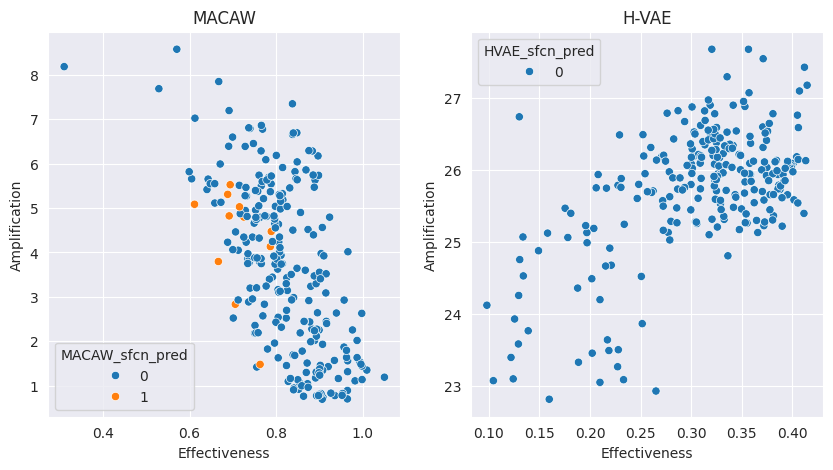

In [82]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x='macaw_bias_removal', y='macaw_unwanted_changes', hue='MACAW_sfcn_pred', data=df, ax=axs[0])
axs[0].set(title='MACAW', xlabel='Effectiveness', ylabel='Amplification')
sns.scatterplot(x='hvae_bias_removal', y='hvae_unwanted_changes', hue='HVAE_sfcn_pred', data=df, ax=axs[1])
axs[1].set(title='H-VAE', xlabel='Effectiveness', ylabel='Amplification')


fig.savefig('sfcn.png')

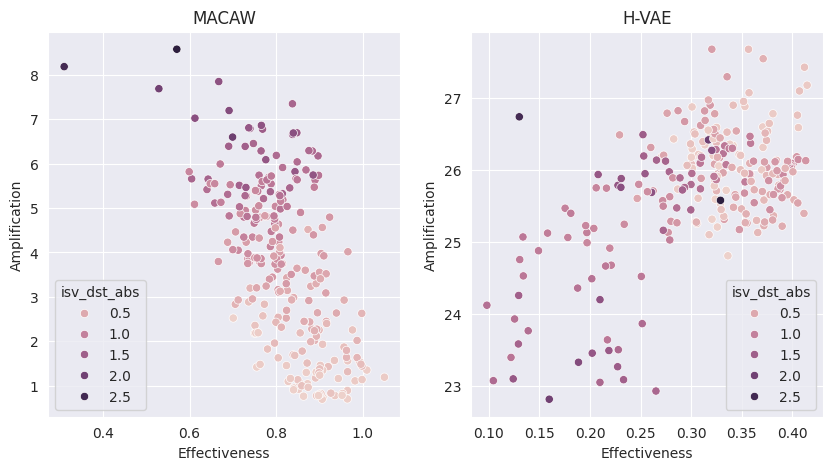

In [81]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x='macaw_bias_removal', y='macaw_unwanted_changes', hue='isv_dst_abs', data=df, ax=axs[0])
axs[0].set(title='MACAW', xlabel='Effectiveness', ylabel='Amplification')
sns.scatterplot(x='hvae_bias_removal', y='hvae_unwanted_changes', hue='isv_dst_abs', data=df, ax=axs[1])
axs[1].set(title='H-VAE', xlabel='Effectiveness', ylabel='Amplification')

fig.savefig('isv.png')

In [76]:
np.argmax(df['macaw_bias_removal'])

27

1.0 0.0
0.995978010980283 0.0
0.99999845 0.0


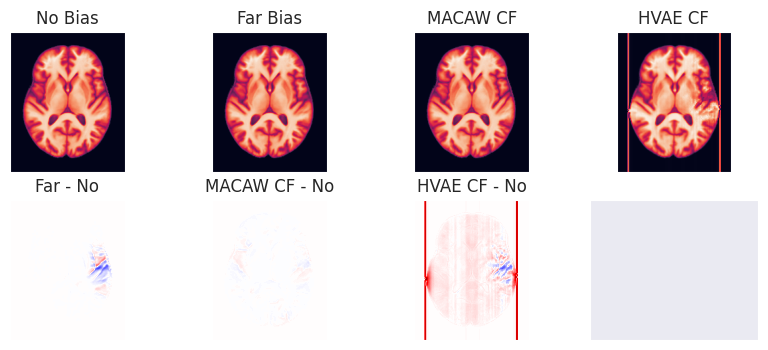

In [77]:
view_images(27)


<Axes: xlabel='subject_effect', ylabel='bias_effect'>

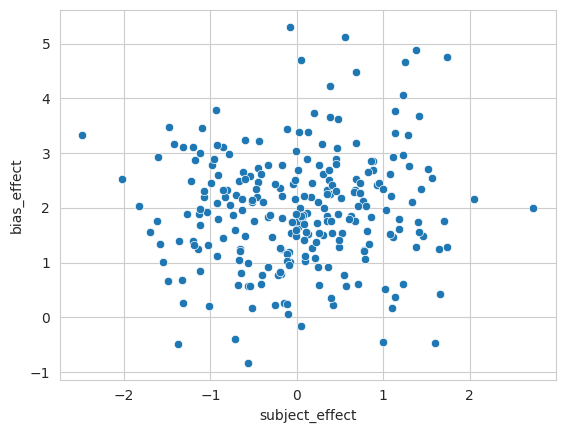

In [51]:
sns.scatterplot(x='subject_effect', y='bias_effect', data=df)

<Axes: xlabel='subject_effect', ylabel='bias_effect'>

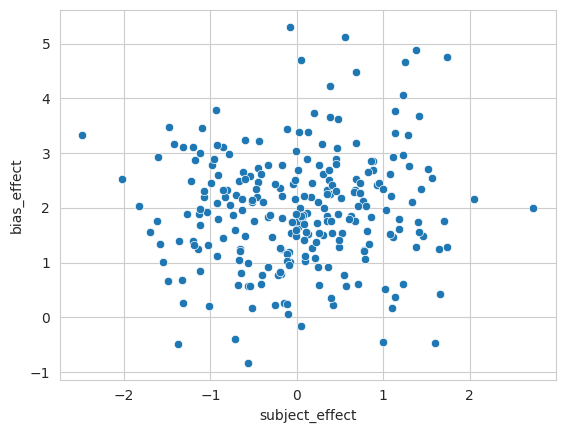

In [51]:
sns.scatterplot(x='subject_effect', y='bias_effect', data=df)

<Axes: xlabel='bias_effect', ylabel='disease_effect'>

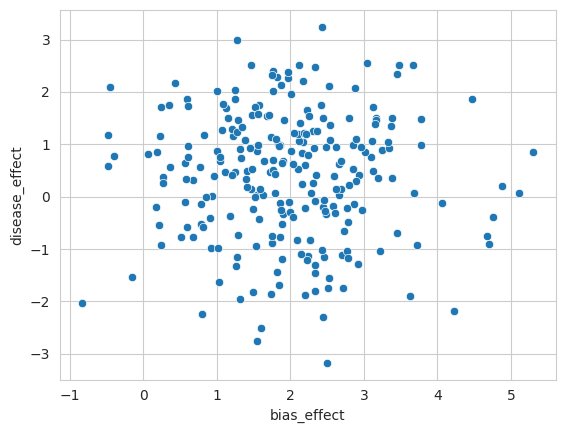

In [53]:
sns.scatterplot(x='bias_effect', y='disease_effect', data=df)